## Imports

In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn import tree, preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import seaborn as sns
sns.set()



/Users/djurk/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dfload = pd.read_csv('fire_data.csv')

/Users/djurk/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
california = dfload.drop(['Unnamed: 0', 'CONTDATE','CONT_DAY_OF_WEEK','DATE','FIRE_SIZE_CLASS', 'CONT_MONTH', 'SOURCE_SYSTEM_TYPE'], axis=1)

In [4]:
#Looking at only California
california = california[california['STATE']=='CA']
ca_target = pd.DataFrame(california['STAT_CAUSE_DESCR'])

In [5]:
california = california.drop(['STAT_CAUSE_DESCR', 'STATE'], axis=1)

In [6]:
california = california.fillna(-100)

In [7]:
#turning text into numbers
le = preprocessing.LabelEncoder()
california['DISC_DAY_OF_WEEK'] = le.fit_transform(california['DISC_DAY_OF_WEEK'])
california.head()

,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE,OWNER_CODE,duration,DISC_MONTH,DISC_DAY_OF_WEEK
0,2005,40.036944,-121.005833,0.10,5.0,0.187500,2,6
1,2004,38.933056,-120.404444,0.25,5.0,0.281250,5,6
2,2004,38.984167,-120.735556,0.10,13.0,0.043750,5,1
3,2004,38.559167,-119.913333,0.10,5.0,4.916667,6,1
4,2004,38.559167,-119.933056,0.10,5.0,4.833333,6,1


In [8]:
#bin classes into 4 types instead of 13
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     

ca_target['LABEL'] = ca_target['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) 
ca_target = ca_target.drop('STAT_CAUSE_DESCR',axis=1)
ca_target.head()

,LABEL
0,4
1,1
2,2
3,1
4,1


In [9]:
X = california
y = ca_target
X_train_val,X_test,y_train_val,y_test = train_test_split(X,y,test_size = 0.3, random_state = 10, stratify = y)
#test holdout

## Tree Classifier validating

In [61]:
treeacc = []
treeprec = []
treerec = []
treef1 = []
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_train_val,y_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]

    tree = DecisionTreeClassifier()
    tree.fit(X_train,y_train)
    tree_pred = tree.predict(X_val)
    
    print('Tree Accuracy: ', accuracy_score(y_val, tree_pred))
    print('Tree Precision: ', precision_score(y_val, tree_pred,average='macro'))
    print('Tree Recall: ', recall_score(y_val, tree_pred,average='macro'))
    print('Tree f1: ', f1_score(y_val, tree_pred,average='macro'))
    treeacc.append(accuracy_score(y_val, tree_pred))
    treeprec.append(precision_score(y_val, tree_pred,average='macro'))
    treerec.append(recall_score(y_val, tree_pred,average='macro'))
    treef1.append(f1_score(y_val, tree_pred,average='macro'))

print('Mean Tree Accuracy: ', np.mean(treeacc))
print('Mean Tree Precision: ', np.mean(treeprec))
print('Mean Tree Recall: ', np.mean(treerec))
print('Mean Tree f1: ', np.mean(treef1))


Tree Accuracy:  0.516316225789434
Tree Precision:  0.5143286411442619
Tree Recall:  0.5164762316005584
Tree f1:  0.5153480026580692
Tree Accuracy:  0.5183887256010249
Tree Precision:  0.5115367521305398
Tree Recall:  0.5197615983530116
Tree f1:  0.5154680974005597
Tree Accuracy:  0.517993744583035
Tree Precision:  0.5138191438207617
Tree Recall:  0.52002481444596
Tree f1:  0.5167559691829975
Tree Accuracy:  0.5138485887628594
Tree Precision:  0.5122764213105223
Tree Recall:  0.5170612401300709
Tree f1:  0.5144702578958297
Tree Accuracy:  0.515055586960618
Tree Precision:  0.5118950317538122
Tree Recall:  0.5131641379004875
Tree f1:  0.5124980315496477
Mean Tree Accuracy:  0.5163205743393944
Mean Tree Precision:  0.5127711980319797
Mean Tree Recall:  0.5172976044860177
Mean Tree f1:  0.5149080717374208


## Random Forest Validating

In [67]:
rfcacc = []
rfcprec = []
rfcrec = []
rfcf1 = []
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_train_val,y_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]

    rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, 
                            max_features=5,
                            max_depth=30,
                            min_samples_leaf=1,
                            min_samples_split=2)
    rfc.fit(X_train,y_train)
    rfc_pred = rfc.predict(X_val)
    
    print('RFC Accuracy: ',accuracy_score(y_val, rfc_pred))
    print('RFC Precision: ',precision_score(y_val, rfc_pred,average='macro'))
    print('RFC Recall: ',recall_score(y_val, rfc_pred,average='macro'))
    print('RFC f1: ',f1_score(y_val, rfc_pred,average='macro'))
    rfcacc.append(accuracy_score(y_val, rfc_pred))
    rfcprec.append(precision_score(y_val, rfc_pred,average='macro'))
    rfcrec.append(recall_score(y_val, rfc_pred,average='macro'))
    rfcf1.append(f1_score(y_val, rfc_pred,average='macro'))

print('Mean RFC Accuracy: ', np.mean(rfcacc))
print('Mean RFC Precision: ', np.mean(rfcprec))
print('Mean RFC Recall: ', np.mean(rfcrec))
print('Mean RFC f1: ', np.mean(rfcf1))
    

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RFC Accuracy:  0.6095033536815133
RFC Precision:  0.6508503316413149
RFC Recall:  0.5910176120737618
RFC f1:  0.6078444179549122


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RFC Accuracy:  0.6117642625668852
RFC Precision:  0.6495758117475677
RFC Recall:  0.5927596497168874
RFC f1:  0.608421371628465


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RFC Accuracy:  0.6105814523118664
RFC Precision:  0.6503733458171108
RFC Recall:  0.5918212349368688
RFC f1:  0.6086561231220563


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RFC Accuracy:  0.6144628254889399
RFC Precision:  0.652441361433699
RFC Recall:  0.596047927645217
RFC f1:  0.612423225715834


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RFC Accuracy:  0.6123233465234595
RFC Precision:  0.651863998201478
RFC Recall:  0.5886201145765367
RFC f1:  0.6061395651192647
Mean RFC Accuracy:  0.6117270481145329
Mean RFC Precision:  0.6510209697682341
Mean RFC Recall:  0.5920533077898543
Mean RFC f1:  0.6086969407081065


In [64]:
#max_features = 5: 0.519
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1,verbose=1, 
                            max_features=5,
                            max_depth=14,
                            min_samples_leaf=1,
                            min_samples_split=2)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_val)

print('RFC Accuracy: ', accuracy_score(y_val, rfc_pred))
print('RFC Precision: ', precision_score(y_val, rfc_pred,average='macro'))
print('RFC Recall: ', recall_score(y_val, rfc_pred,average='macro'))
print('RFC f1: ', f1_score(y_val, rfc_pred,average='macro'))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   35.7s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.8s finished


RFC Accuracy:  0.6125494629734313
RFC Precision:  0.6682523061088818
RFC Recall:  0.5738654801367745
RFC f1:  0.5940395420899218


In [15]:
wrfc = RandomForestClassifier(n_estimators=1000, verbose=1, n_jobs=2, class_weight={1:3, 2:1, 3:4, 4:1})
wrfc.fit(X_train,y_train)
wrfc_pred = rfc.predict(X_val)
    
    
print('WRFC Accuracy: ', accuracy_score(y_val, wrfc_pred))
print('WRFC Precision: ', precision_score(y_val, wrfc_pred,average='macro'))
print('WRFC Recall: ', recall_score(y_val, wrfc_pred,average='macro'))
print('WRFC f1: ', f1_score(y_val, wrfc_pred,average='macro'))


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   11.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   26.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   47.0s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   59.0s finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    4.9s


WRFC Accuracy:  0.6099582977440586
WRFC Precision:  0.6553787496453722
WRFC Recall:  0.5882514893263178
WRFC f1:  0.6046458519675797


[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    6.1s finished


## BOOST VALIDATING - xgboost was doing the best on initial tests, so I'll be further tuning this model

In [59]:
#max depth = 9: 0.6151
#max subsample = 0.9: 0.6155
#max child_weight = 2: 0.6155
#max colsample_bytree = 0.7: 0.6155
#max learning_rate =0.08: 0.6156

#CV
boostacc = []
boostprec = []
boostrec = []
boostf1 = []
skf = StratifiedKFold(n_splits=5)
for train_index, test_index in skf.split(X_train_val,y_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]

    boost = xgb.XGBClassifier(max_depth=9,
                          subsample=0.9,
                          objective='multi:softmax',
                          num_class = 4,
                          min_child_weight=2,
                          colsample_bytree=0.7,
                          n_estimators=1000,
                          learning_rate=0.08,
                          n_jobs = -1)
    boost.fit(X_train,y_train)
    boost_pred = boost.predict(X_val)
    
    print('Boost Accuracy: ',accuracy_score(y_val, boost_pred))
    print('Boost Precision: ',precision_score(y_val, boost_pred,average='macro'))
    print('Boost Recall: ',recall_score(y_val, boost_pred,average='macro'))
    print('Boost f1: ',f1_score(y_val, boost_pred,average='macro'))
    boostacc.append(accuracy_score(y_val, boost_pred))
    boostprec.append(precision_score(y_val, boost_pred,average='macro'))
    boostrec.append(recall_score(y_val, boost_pred,average='macro'))
    boostf1.append(f1_score(y_val, boost_pred,average='macro'))

print('Mean Boost Accuracy: ', np.mean(boostacc))
print('Mean Boost Precision: ', np.mean(boostprec))
print('Mean Boost Recall: ', np.mean(boostrec))
print('Mean Boost f1: ', np.mean(boostf1))


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expect

Boost Accuracy:  0.6226166252166704
Boost Precision:  0.6667688084307388
Boost Recall:  0.5986284891663044
Boost f1:  0.6163155524203392


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Boost Accuracy:  0.6202049890722737
Boost Precision:  0.6614823689700644
Boost Recall:  0.5994590105601543
Boost f1:  0.6155039712341066


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Boost Accuracy:  0.6215472736179674
Boost Precision:  0.6643158244393792
Boost Recall:  0.5989403049739248
Boost f1:  0.6152056590998871


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Boost Accuracy:  0.6213588574443231
Boost Precision:  0.6653486705820475
Boost Recall:  0.5999301920378689
Boost f1:  0.6174127807759855
Boost Accuracy:  0.6214433766723195
Boost Precision:  0.6638971544688478
Boost Recall:  0.5962075002730598
Boost f1:  0.613108968945759
Mean Boost Accuracy:  0.6214342244047109
Mean Boost Precision:  0.6643625653782156
Mean Boost Recall:  0.5986330994022625
Mean Boost f1:  0.6155093864952155


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [37]:
#weights performed exact same as without weights
boost = xgb.XGBClassifier(max_depth=9,
                          subsample=0.9,
                          objective='multi:softmax',
                          num_class = 4,
                          min_child_weight=2,
                          colsample_bytree=0.7,
                          n_estimators=1000,
                          learning_rate=0.08,
                          n_jobs = -1,class_weight={1:3, 2:1, 3:4, 4:1})

boost.fit(X_train,y_train)
boost_pred = boost.predict(X_val)
print('Accuracy: ',accuracy_score(y_val,boost_pred))
print('Precision: ',precision_score(y_val,boost_pred,average='macro'))
print('Recall: ',recall_score(y_val,boost_pred,average='macro'))
print('f1: ',f1_score(y_val,boost_pred,average='macro'))
print(classification_report(y_val,boost_pred))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.62000703411546
Precision:  0.6625493816294388
Recall:  0.5996584224821168
f1:  0.6156147505124606
             precision    recall  f1-score   support

          1       0.81      0.84      0.82      5670
          2       0.59      0.69      0.64     16457
          3       0.68      0.34      0.46      4123
          4       0.57      0.52      0.54     13556

avg / total       0.62      0.62      0.61     39806



/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## FINAL TEST SCORE

In [68]:
boost = xgb.XGBClassifier(max_depth=9,
                          subsample=0.9,
                          objective='multi:softmax',
                          num_class = 3,
                          min_child_weight=2,
                          colsample_bytree=0.7,
                          n_estimators=1000,
                          learning_rate=0.08,
                          n_jobs = -1)
boost.fit(X_train_val,y_train_val)
boost_pred = boost.predict(X_test)
    
print('Boost Accuracy: ',accuracy_score(y_test, boost_pred))
print('Boost Precision: ',precision_score(y_test, boost_pred,average='macro'))
print('Boost Recall: ',recall_score(y_test, boost_pred,average='macro'))
print('Boost f1: ',f1_score(y_test, boost_pred,average='macro'))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Boost Accuracy:  0.6287171370790469
Boost Precision:  0.6740284936077257
Boost Recall:  0.6048331498752041
Boost f1:  0.6231626290001091


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [125]:
list(zip((X.columns,boost.feature_importances_)))

[(Index(['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'FIRE_SIZE', 'OWNER_CODE',
         'duration', 'DISC_MONTH', 'DISC_DAY_OF_WEEK'],
        dtype='object'),),
 (array([0.12243054, 0.22239165, 0.2174799 , 0.10309161, 0.04582519,
         0.12533903, 0.08382325, 0.07961883], dtype=float32),)]

In [71]:
PREDS = pd.DataFrame(boost_pred)

In [86]:
PREDS.head()

,0
0,4
1,4
2,1
3,4
4,4


In [79]:
X_test.tail()

,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE,OWNER_CODE,duration,DISC_MONTH,DISC_DAY_OF_WEEK
1141183,1997,33.765000,-117.283056,1.0,14.0,-100.000000,6,3
214733,1998,37.925950,-120.277800,0.1,8.0,0.000000,9,2
1124606,1997,40.208056,-122.208056,2.0,14.0,-100.000000,5,3
1076823,2007,37.380000,-120.605000,0.1,14.0,-100.000000,5,3
29178,2008,37.095556,-119.352500,0.6,5.0,0.104167,7,3


In [93]:
COMPARE = y_test.copy().reset_index()
COMPARE['preds'] = PREDS[0]

In [99]:
COMPARE.head()

,LABEL,preds
0,2,4
1,4,4
2,2,1
3,4,4
4,4,4


## Separating actual causes and predicted causes to make Tableau visualization

In [109]:
ACTUAL = X_test.copy()
ACTUAL['ACTUAL LABEL'] = y_test


In [110]:
ACTUAL.head()

,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE,OWNER_CODE,duration,DISC_MONTH,DISC_DAY_OF_WEEK,ACTUAL LABEL
1653759,2013,39.175667,-121.246767,0.25,14.0,0.010417,5,2,2
1778923,2014,36.952550,-119.747650,2.00,14.0,0.027083,6,4,4
103611,1997,41.300000,-123.233333,0.10,5.0,0.322917,9,2,2
314321,2000,33.707000,-117.232089,0.10,8.0,-100.000000,10,0,4
312245,2005,35.587961,-118.489394,0.10,8.0,-100.000000,8,0,4


In [117]:
PREDICTS = X_test.copy().reset_index()
PREDICTS['PREDICTED LABEL'] = PREDS[0]
PREDICTS = PREDICTS.drop(['index'],axis = 1)

In [118]:
PREDICTS.head()

,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE,OWNER_CODE,duration,DISC_MONTH,DISC_DAY_OF_WEEK,PREDICTED LABEL
0,2013,39.175667,-121.246767,0.25,14.0,0.010417,5,2,4
1,2014,36.952550,-119.747650,2.00,14.0,0.027083,6,4,4
2,1997,41.300000,-123.233333,0.10,5.0,0.322917,9,2,1
3,2000,33.707000,-117.232089,0.10,8.0,-100.000000,10,0,4
4,2005,35.587961,-118.489394,0.10,8.0,-100.000000,8,0,4


In [119]:
ACTUAL.to_csv('actual.csv')

In [120]:
PREDICTS.to_csv('predicted.csv')

In [12]:
california_pred = california.copy()
california_pred['LABEL'] = y['LABEL']

In [13]:
california_pred.head()

,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE,OWNER_CODE,duration,DISC_MONTH,DISC_DAY_OF_WEEK,LABEL
0,2005,40.036944,-121.005833,0.10,5.0,0.187500,2,6,4
1,2004,38.933056,-120.404444,0.25,5.0,0.281250,5,6,1
2,2004,38.984167,-120.735556,0.10,13.0,0.043750,5,1,2
3,2004,38.559167,-119.913333,0.10,5.0,4.916667,6,1,1
4,2004,38.559167,-119.933056,0.10,5.0,4.833333,6,1,1


In [14]:
cal_train = california_pred[california_pred['LABEL']!=4]

In [15]:
len(cal_train)

125002

In [16]:
cal_test = california_pred[california_pred['LABEL']==4]

In [17]:
len(cal_test)

64548

## Predicting Unknown Causes

In [18]:
X_train = cal_train.drop(['LABEL'],axis=1)
y_train = cal_train['LABEL']
X_test = cal_test.drop(['LABEL'],axis=1)

In [19]:
boost = xgb.XGBClassifier(max_depth=9,
                          subsample=0.9,
                          objective='multi:softmax',
                          num_class = 3,
                          min_child_weight=2,
                          colsample_bytree=0.7,
                          n_estimators=1000,
                          learning_rate=0.08,
                          n_jobs = -1)
boost.fit(X_train,y_train)
boost_preds = boost.predict(X_test)
    


In [20]:
BOOSTED_PREDICTIONS = pd.DataFrame(boost_preds)

In [21]:
BOOSTED_PREDICTIONS[0].value_counts()

2    58976
3     2816
1     2756
Name: 0, dtype: int64

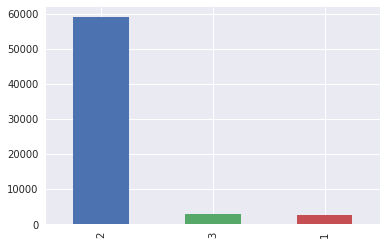

In [191]:
BOOSTED_PREDICTIONS[0].value_counts().plot(kind = 'bar')

In [177]:
ARSON = X_test.copy().reset_index()
ARSON['PREDICTION'] = BOOSTED_PREDICTIONS[0]

In [178]:
ARSON

,index,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE,OWNER_CODE,duration,DISC_MONTH,DISC_DAY_OF_WEEK,PREDICTION
0,0,2005,40.036944,-121.005833,0.10,5.0,0.187500,2,6,2
1,12,2004,38.786667,-120.193333,0.10,5.0,0.020833,9,0,2
2,87,2005,34.174444,-117.765000,0.10,5.0,0.024306,4,3,2
3,105,2005,33.666667,-117.376389,0.10,13.0,0.010417,4,6,2
4,146,2005,35.768889,-118.435278,0.10,13.0,0.022222,5,1,2
5,171,2005,38.763889,-119.853889,0.10,5.0,0.027083,7,5,1
6,178,2005,35.135833,-120.002500,90.00,5.0,2.187500,7,0,1
7,183,2005,34.471389,-119.195000,1.00,13.0,0.086111,7,1,2
8,211,2005,35.702222,-118.453611,1.10,5.0,0.103472,5,3,2
9,214,2005,35.678611,-118.409444,0.10,5.0,0.010417,6,4,2


In [176]:
len(X_test)

64548

In [179]:
ARSONS = ARSON[ARSON['PREDICTION']==3]

## All these were predicted as arson!  Perhaps they could be looked into again.

In [180]:
ARSONS

,index,FIRE_YEAR,LATITUDE,LONGITUDE,FIRE_SIZE,OWNER_CODE,duration,DISC_MONTH,DISC_DAY_OF_WEEK,PREDICTION
31,1082,2005,36.159167,-118.712500,22.00,5.0,0.107639,7,6,3
57,2095,2005,34.266389,-117.835833,5.00,5.0,0.327778,8,2,3
58,2110,2005,34.219722,-117.869167,20.00,5.0,0.459028,9,1,3
85,3088,2005,41.335278,-123.554722,0.10,5.0,0.063889,9,2,3
158,4313,2005,34.288056,-118.176667,0.10,5.0,0.094444,1,1,3
159,4314,2005,34.292778,-118.231111,1.00,5.0,0.072917,2,6,3
160,4318,2005,34.303333,-118.259722,0.10,5.0,0.032639,6,3,3
181,4913,2005,34.174444,-117.775556,0.10,5.0,0.135417,11,3,3
212,6090,2005,34.316111,-118.384167,0.80,5.0,0.010417,1,4,3
213,6092,2005,34.306944,-118.287500,0.10,5.0,0.045139,3,2,3
